In [2]:
import numpy as np
import math
import pandas as pd

from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization mode
from geneticalgorithm2 import Generation, AlgorithmParams # classes for comfortable parameters setting and getting
from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior
from geneticalgorithm2 import Population_initializer # for creating better start population
from geneticalgorithm2 import np_lru_cache # for cache function (if u want)
from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want
from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

In [3]:
 #read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
data = pd.read_csv ('data_6_3_LINGO.csv')
df = pd.DataFrame(data)

b3 = df[["B3"]].to_numpy()
b4 = df[["B4"]].to_numpy()
b5 = df[["B5"]].to_numpy()

# profit contribution per 1000 feet
profits = [15.89, 17.89, 16.5, 15.22, 17.5, 16.22]

cota_maxima_benef = profits[0]*315 + profits[1]*315 + profits[2]*210 + profits[3]*157.5 + profits[4]*210 + profits[5]*157.5
cota_maxima_1000s = 315+315+210+157.5+210+157.5

In [4]:
def f(X):
    pen = 0
    if 1000/(b3[0]*60)*X[0] + 1000/(b3[0]*60)*X[1] > b3[1]:
        pen += cota_maxima_benef + 10000*(1000/(b3[0]*60)*X[0] + 1000/(b3[0]*60)*X[1] - b3[1])
    if 1000/(b4[0]*60)*X[2] + 1000/(b4[0]*60)*X[4] > b4[1]:
        pen += cota_maxima_benef + 10000*(1000/(b4[0]*60)*X[2] + 1000/(b4[0]*60)*X[4] - b4[1])
    if 1000/(b5[0]*60)*X[3] + 1000/(b5[0]*60)*X[5] > b5[1]:
        pen += cota_maxima_benef + 10000*(1000/(b5[0]*60)*X[3] + 1000/(b5[0]*60)*X[5] - b5[1])
    if X[0]+X[1]+X[2]+X[3]+X[4]+X[5] > 600:
        pen += cota_maxima_benef + 10000*(X[0]+X[1]+X[2]+X[3]+X[4]+X[5] - 600)
    if X[1] + X[2] + X[3] < 114:
        pen += (315+210+157.5) + 10000*abs(X[1] + X[2] + X[3] - 114)
    if X[4] + X[5] < 111:
        pen += (210+157.5) + 10000*abs(X[4] + X[5] - 111)
        
    res = float(profits[0]*X[0]) + float(profits[1]*X[1]) + float(profits[2]*X[2]) + float(profits[3]*X[3]) + float(profits[4]*X[4]) + float(profits[5]*X[5]) - float(pen)
    return -res
    

In [5]:
algorithm_param = {'max_num_iteration': 1000,\
                   'population_size': 1000,\
                   'mutation_probability':0.5,\
                   'elit_ratio': 0.0,\
                   'parents_portion': 0.3,\
                   'crossover_type':'one_point',\
                   'mutation_type':'gauss_by_center',\
                   'selection_type':'tournament',\
                   'max_iteration_without_improv':None}


Average time of function evaluating (secs): 0.0004914960861206055 (total = 0.49149608612060547)

Best score before optimization: -9795.410978948663
                                                                                                                                                                                                        
 The best found solution:
 [218.22623367  94.47262034  23.39494791   3.37250059 182.27274833
  78.19982232]

 Objective function:
 -10053.25034418257

 Used generations: 1000
 Used time: 97.6 seconds


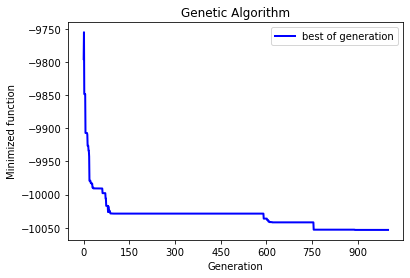

In [6]:
import time

#              B34      B38     B48      B58      B42      B52
varbound = [[218,315],[0,315],[0,210],[0,157.5],[0,210],[0,157.5]]

model=ga(function=f,dimension=6,variable_type='real',variable_boundaries=varbound, algorithm_parameters=algorithm_param)

result = model.run()

In [7]:
print(result.variable)
print(result.score)

[218.22623367  94.47262034  23.39494791   3.37250059 182.27274833
  78.19982232]
-10053.25034418257


## Aplicar descenso de gradiente

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

x = pd.DataFrame(result.variable, columns = ['solution'])
y = pd.DataFrame(np.array([[result.score]]), columns = ['profit'])
X = x.apply(lambda rec:(rec-rec.mean())/rec.std(),axis=0).T
Y = np.array(y/y)

In [9]:
import random

def initialize(dim):
    b=random.random()
    theta=np.random.rand(dim)
    return b,theta

In [10]:
def predict_Y(b,theta,X):
    #print(theta.ravel())
    return b + np.dot(X.to_numpy().ravel(),theta.ravel())

In [11]:
import math

def get_cost(Y,Y_hat):
    Y_resd=Y-Y_hat
    #print("cost:",Y_resd)
    return np.sum(np.dot(Y_resd.T,Y_resd))/len(Y-Y_resd)

In [12]:
def update_theta(x,y,y_hat,b_0,theta_o,learning_rate):
    db=(np.sum(y_hat-y)*2)/len(y)
    dw=(np.dot((y_hat-y),x)*2)/len(y)
    b_1=b_0-learning_rate*db
    theta_1=theta_o-learning_rate*dw
    return b_1,theta_1

In [13]:
def run_gradient_descent(X,Y,alpha,num_iterations):
    b,theta=initialize(6)
    iter_num=0
    gd_iterations_df=pd.DataFrame(columns=['iteration','cost'])
    result_idx=0
    for each_iter in range(num_iterations):
        Y_hat=predict_Y(b,theta,X)
        this_cost=get_cost(Y,Y_hat)
        print("cost: ",this_cost)
        prev_b=b
        prev_theta=theta
        b,theta=update_theta(X,Y,Y_hat,prev_b,prev_theta,alpha)
        if(iter_num%10==0):
            gd_iterations_df.loc[result_idx]=[iter_num,this_cost]
        result_idx=result_idx+1
        iter_num +=1
    print("Final Estimate of b and theta : ",b,theta)
    return gd_iterations_df,b,theta

gd_iterations_df,b,theta=run_gradient_descent(X,Y,alpha=0.001,num_iterations=200)

cost:  2.5758913279383835
cost:  2.514440864419085
cost:  2.454456363157503
cost:  2.3959028521580183
cost:  2.3387461937169363
cost:  2.2829530645196257
cost:  2.228490936212445
cost:  2.1753280564381616
cost:  2.123433430323773
cost:  2.0727768024099684
cost:  2.0233286390116767
cost:  1.975060110999414
cost:  1.9279430769914119
cost:  1.881950066946705
cost:  1.8370542661496234
cost:  1.7932294995763585
cost:  1.7504502166344647
cost:  1.708691476266433
cost:  1.667928932408621
cost:  1.6281388197970805
cost:  1.5892979401120018
cost:  1.5513836484526893
cost:  1.5143738401352018
cost:  1.478246937804936
cost:  1.4429818788566617
cost:  1.4085581031546577
cost:  1.3749555410457992
cost:  1.3421546016586112
cost:  1.3101361614814429
cost:  1.2788815532131412
cost:  1.248372554879689
cost:  1.2185913792104794
cost:  1.189520663268034
cost:  1.1611434583251115
cost:  1.1334432199833078
cost:  1.1064037985273856
cost:  1.0800094295097162
cost:  1.0542447245593323
cost:  1.02909466241024

In [14]:
gd_iterations_df[0:10]

,iteration,cost
0,0.0,2.575891
10,10.0,2.023329
20,20.0,1.589298
30,30.0,1.248373
40,40.0,0.980580
50,50.0,0.770233
60,60.0,0.605008
70,70.0,0.475226
80,80.0,0.373283
90,90.0,0.293209


In [19]:
print(theta.ravel())

[0.78807444 0.91020231 0.76041188 0.40932519 0.77550453 0.46996353]


In [16]:
res = f(theta)
print(res)

IndexError: index 1 is out of bounds for axis 0 with size 1